In this file I extract the raw data channels from rat, detect ripples, and save them for each channel with help of jagular and nelpy.

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter("ignore", UserWarning)
import nelpy as nel
import nelpy.plotting as npl
import jagular as jag

prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec_list = ['preFamSleep', 'fam', 'postFamSleep', 'test', 'postTestSleep']

# Unpack Wrath Data

In [7]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec_list = ['preFamSleep', 'fam', 'postFamSleep', 'test', 'postTestSleep']

for i in range(len(rec_list)):
    rec = rec_list[i]
    files = prefix + rec + '.rec'
    os.system("mkdir " + prefix + rec + "_channels")

    # Jagular Extraction Stuff

    jfm = jag.io.JagularFileMap(files)
    max_gap_size = 10000
    ts_out = prefix + rec + '_timestamps.raw'
    ch_out_prefix = prefix + rec + '_channels/'
    subset = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]
    block_size = 2**21
    verbose = False

    #jag.utils.extract_channels(
    #    jfm = jfm,
    #    max_gap_size = max_gap_size,
    #    ts_out = ts_out,
    #    ch_out_prefix = ch_out_prefix,
    #    subset = subset,
    #    block_size = block_size,
    #    verbose = verbose
    #)
    
    print(files)

/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep.rec
/home/kaylavokt/Desktop/Whrath/Day1/fam.rec
/home/kaylavokt/Desktop/Whrath/Day1/postFamSleep.rec
/home/kaylavokt/Desktop/Whrath/Day1/test.rec
/home/kaylavokt/Desktop/Whrath/Day1/postTestSleep.rec


## Load Data into Nelpy Analog Signal Arrays

In [3]:
def loadUpData(prefix, rec, channels, verbose):
    # loadUpData: this function takes in the filepath and type of recording
    # ['preFamSleep', 'fam', 'postFamSleep', 'test', 'postTestSleep']
    # and generates a nelpy analog signal array

    ts = np.fromfile(prefix + rec + '_timestamps.raw', dtype = np.uint32)

    chdata = []
    for i in range(len(channels)):
        if(channels[i]<10):
            chdata.append(np.fromfile(prefix + rec + "_channels/ch.0" + str(channels[i]) + ".raw",dtype=np.int16)*0.195)
            if(verbose):
                print(prefix + rec + "_channels/ch.0" + str(channels[i]) + ".raw")
        else:
            chdata.append(np.fromfile(prefix + rec + "_channels/ch." + str(channels[i]) + ".raw",dtype=np.int16)*0.195)
            if(verbose):
                print(prefix + rec + "_channels/ch." + str(channels[i]) + ".raw")
    
    chdata = np.asarray(chdata)
    return nel.AnalogSignalArray(
    chdata,
    abscissa_vals=(ts-ts[0])/30000,
    )

In [6]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[0]
channels = [0]
asa = loadUpData(prefix, rec, channels, True)
print(asa)


/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.00.raw


<AnalogSignalArray at 0x7f584bbfde80: 1 signals> for a total of 22:45:176 minutes


## Detect Ripples

In [4]:
def extract_ripples(asa):
    eeg = nel.filtering.sosfiltfilt(asa, fl=150, fh=250)
    env = nel.utils.signal_envelope_1d(eeg, sigma=0.004)
    bounds, _, _ = nel.utils.get_events_boundaries(env.data,
    PrimaryThreshold=env.mean() + 3*env.std(),
    SecondaryThreshold=env.mean(),
    minThresholdLength=0.015,
    minLength=0.05,
    ds=1/env.fs)
    timebounds = env.time[bounds]
    timebounds[:, 1] += 1/env.fs
    return nel.EpochArray(timebounds)

In [8]:
# Preprocess by Subsampling
asa = nel.filtering.sosfiltfilt(asa,fl=0.1,fh=400) # lfp/anti-aliasing filter
asa = asa.subsample(fs=3000)

ripple_epochs1 = extract_ripples(asa)

print("Number of Ripples Detected = ", np.size(ripple_epochs1.lengths))


/home/kaylavokt/nelpy/nelpy/utils.py:1225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Number of Ripples Detected =  70


/home/kaylavokt/nelpy/nelpy/utils.py:1262: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/kaylavokt/nelpy/nelpy/utils.py:1263: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/kaylavokt/nelpy/nelpy/utils.py:1264: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Count Ripples for All Channels

In [9]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[0]
channels = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]
asa = loadUpData(prefix, rec, channels, True)
print(asa)


/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.00.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.01.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.02.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.03.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.08.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.09.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.10.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.11.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.16.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.17.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.18.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.19.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.24.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.25.raw
/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.26

<AnalogSignalArray at 0x7f57ed3cf0f0: 16 signals> for a total of 22:45:176 minutes


In [38]:
# asa = nel.filtering.sosfiltfilt(asa,fl=0.1,fh=400) # lfp/anti-aliasing filter
# asa = asa.subsample(fs=3000)

# ripple_epochs = []
# for s in range(len(channels)):
#     # s stands for signal number in analog signal array
#     epoch = extract_ripples(asa[:,s])
#     ripple_epochs.append(epoch)
#     print("Number of Ripples Detected from Channel ", channels[s], " = ", np.size(epoch.lengths))


In [10]:
asa = nel.filtering.sosfiltfilt(asa,fl=0.1,fh=400) # lfp/anti-aliasing filter
asa = asa.subsample(fs=3000)
channels = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]

ripple_epochs = []

for s in range(16):
    epoch = extract_ripples(asa[:,s])
    ripple_epochs.append(epoch)
    print("Number of Ripples Detected from Channel ", channels[s], " = ", np.size(epoch.lengths))



Number of Ripples Detected from Channel  0  =  70
Number of Ripples Detected from Channel  1  =  58


In [18]:
ripple_epochs

[<EpochArray at 0x7f583b7d4128: 70 epochs> of length 9.45530000000000004 seconds,
 <EpochArray at 0x7f57cfe6f400: 58 epochs> of length 8.2627 seconds,
 <EpochArray at 0x7f57cfe6fb00: 64 epochs> of length 9.018699999999999998 seconds,
 <EpochArray at 0x7f584804d748: 55 epochs> of length 7.792 seconds,
 <EpochArray at 0x7f57cfe6f588: 50 epochs> of length 7.506 seconds,
 <EpochArray at 0x7f57cfe70ba8: 48 epochs> of length 7.36369999999999997 seconds,
 <EpochArray at 0x7f57cfe758d0: 71 epochs> of length 10.2897 seconds,
 <EpochArray at 0x7f583b7d46a0: 51 epochs> of length 7.666 seconds,
 <EpochArray at 0x7f57ed3cfbe0: 216 epochs> of length 23.748 seconds,
 <EpochArray at 0x7f57cfe49c88: 229 epochs> of length 25.0843 seconds,
 <EpochArray at 0x7f57cfe49710: 186 epochs> of length 20.8717 seconds,
 <EpochArray at 0x7f57ed366208: 199 epochs> of length 22.573 seconds,
 <EpochArray at 0x7f57cfe757f0: 168 epochs> of length 19.5842999999999999 seconds,
 <EpochArray at 0x7f57cfe70320: 141 epochs> o

In [20]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[0]
path = prefix + rec + '_channels/ripple_epochs.npy'
np.save(path, ripple_epochs)

# np.load(path, allow_pickle=True)

## Save Ripple Epochs for each Recording Type

In [24]:
print("~~~ Load Up Data ~~~")
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[1] ## Change this for each Type of Recording
channels = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]
asa = loadUpData(prefix, rec, channels, True)
print(asa)

print("~~~ Extract Ripples ~~~")
asa = nel.filtering.sosfiltfilt(asa,fl=0.1,fh=400) # lfp/anti-aliasing filter
asa = asa.subsample(fs=3000)

ripple_epochs = []

for s in range(16):
    epoch = extract_ripples(asa[:,s])
    ripple_epochs.append(epoch)
    print("Number of Ripples Detected from Channel ", channels[s], " = ", np.size(epoch.lengths))
    
print("~~~ Ripple Epochs ~~~")
print(ripple_epochs)

print("~~~ Saving Ripple Epochs to npy ~~~")
path = prefix + rec + '_channels/ripple_epochs.npy'
np.save(path, ripple_epochs)

~~~ Load Up Data ~~~
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.00.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.01.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.02.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.03.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.08.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.09.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.10.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.11.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.16.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.17.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.18.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.19.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.24.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.25.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.26.raw
/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.27.raw


<AnalogSignalArray at 0x7f581dec5da0: 16 signals> for a total of 10:35:616 minutes
~~~ Extract Ripples ~~~
Number of Ripples Detected from Channel  0  =  18
Number of Ripples Detected from Channel  1  =  32
Number of Ripples Detected from Channel  2  =  28
Number of Ripples Detected from Channel  3  =  32
Number of Ripples Detected from Channel  8  =  17
Number of Ripples Detected from Channel  9  =  20
Number of Ripples Detected from Channel  10  =  21
Number of Ripples Detected from Channel  11  =  18
Number of Ripples Detected from Channel  16  =  26
Number of Ripples Detected from Channel  17  =  22
Number of Ripples Detected from Channel  18  =  19
Number of Ripples Detected from Channel  19  =  37
Number of Ripples Detected from Channel  24  =  31
Number of Ripples Detected from Channel  25  =  24
Number of Ripples Detected from Channel  26  =  26
Number of Ripples Detected from Channel  27  =  22
~~~ Ripple Epochs ~~~
[<EpochArray at 0x7f581dee7ba8: 18 epochs> of length 4.492699

## Get Noise Channel

In [5]:
prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec_list = ['preFamSleep', 'fam', 'postFamSleep', 'test', 'postTestSleep']

for i in range(len(rec_list)):
    rec = rec_list[i]
    files = prefix + rec + '.rec'

    # Jagular Extraction Stuff

    jfm = jag.io.JagularFileMap(files)
    max_gap_size = 10000
    ts_out = prefix + rec + '_timestamps.raw'
    ch_out_prefix = prefix + rec + '_channels/noise_'
    subset = [20] ## This is where we specify the Noise Channel
    block_size = 2**21
    verbose = False

    jag.utils.extract_channels(
       jfm = jfm,
       max_gap_size = max_gap_size,
       ts_out = ts_out,
       ch_out_prefix = ch_out_prefix,
       subset = subset,
       block_size = block_size,
       verbose = verbose
    )
    
    print(files)


/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep.rec
/home/kaylavokt/Desktop/Whrath/Day1/fam.rec
/home/kaylavokt/Desktop/Whrath/Day1/postFamSleep.rec
/home/kaylavokt/Desktop/Whrath/Day1/test.rec
/home/kaylavokt/Desktop/Whrath/Day1/postTestSleep.rec


In [6]:
    
def loadUpNoise(prefix, rec, channels, verbose):
    # loadUpData: this function takes in the filepath and type of recording
    # ['preFamSleep', 'fam', 'postFamSleep', 'test', 'postTestSleep']
    # and generates a nelpy analog signal array

    ts = np.fromfile(prefix + rec + '_timestamps.raw', dtype = np.uint32)

    chdata = []
    for i in range(len(channels)):
        if(channels[i]<10):
            chdata.append(np.fromfile(prefix + rec + "_channels/noise_ch.0" + str(channels[i]) + ".raw",dtype=np.int16)*0.195)
            if(verbose):
                print(prefix + rec + "_channels/noise_ch.0" + str(channels[i]) + ".raw")
        else:
            chdata.append(np.fromfile(prefix + rec + "_channels/noise_ch." + str(channels[i]) + ".raw",dtype=np.int16)*0.195)
            if(verbose):
                print(prefix + rec + "_channels/noise_ch." + str(channels[i]) + ".raw")
    
    chdata = np.asarray(chdata)
    return nel.AnalogSignalArray(
    chdata,
    abscissa_vals=(ts-ts[0])/30000,
    )

prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[0]
channels = [20]
noise5 = loadUpNoise(prefix, rec, [5], True)
noise20 = loadUpNoise(prefix, rec, [20], True)

print(noise5)
print(noise20)

/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/noise_ch.05.raw


/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/noise_ch.20.raw


<AnalogSignalArray at 0x7f963bd464e0: 1 signals> for a total of 22:45:176 minutes
<AnalogSignalArray at 0x7f963bd46358: 1 signals> for a total of 22:45:176 minutes


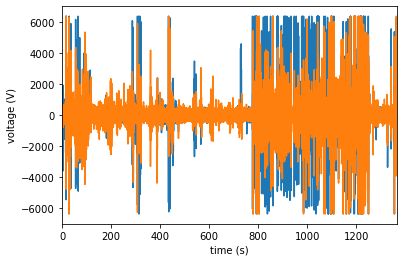

In [8]:
npl.plot(noise5)
npl.plot(noise20)

In [15]:
# noise = nel.filtering.sosfiltfilt(noise20,fl=0.1,fh=400) # lfp/anti-aliasing filter
# noise = noise.subsample(fs=3000) # dont include for HF (both)

# noise = noise20
eeg = nel.filtering.sosfiltfilt(noise20, fl=80, fh=150) # fine rn because not looking at stim artifacts,ghostipy filtering example
# env = nel.utils.signal_envelope_1d(eeg, sigma=0.004)

# npl.plot(noise20)
npl.plot(eeg)
# npl.plot(env)


In [17]:
npl.plot(eeg)
npl.plot(asa + 4000, color='pink')


In [10]:
%matplotlib qt
npl.plot(noise20)

In [13]:
window = [1120,1150]
npl.plot(asa[nel.EpochArray(window)] + 4000, color='blue')
npl.plot(eeg[nel.EpochArray(window)])
npl.plot(env[nel.EpochArray(window)])

In [5]:
def extract_noise(asa):
    eeg = nel.filtering.sosfiltfilt(asa, fl=4, fh=250) # changed lower bound
    env = nel.utils.signal_envelope_1d(eeg, sigma=0.004)
    bounds, _, _ = nel.utils.get_events_boundaries(env.data,
    PrimaryThreshold=env.mean() + 10*env.std(),
    SecondaryThreshold=env.mean(),
    minThresholdLength=0.015,
    minLength=0.05,
    ds=1/env.fs)
    timebounds = env.time[bounds]
    timebounds[:, 1] += 1/env.fs
    return nel.EpochArray(timebounds)

In [36]:
noise5_epochs = extract_noise(noise5)

In [6]:
# noise5_epochs.data

In [11]:
# pre fam sleep

prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[0]
channels = [27]
asa = loadUpData(prefix, rec, channels, True)
print(asa)

/home/kaylavokt/Desktop/Whrath/Day1/preFamSleep_channels/ch.27.raw


<AnalogSignalArray at 0x7f963b573048: 1 signals> for a total of 22:45:176 minutes


In [43]:
asa_epochs = extract_ripples(asa)

In [7]:
# asa_epochs.data

In [12]:
npl.plot(asa)

In [28]:
# familiarization

prefix = '/home/kaylavokt/Desktop/Whrath/Day1/'
rec = rec_list[1]
channels = [27]
asa = loadUpData(prefix, rec, channels, True)
print(asa)

path = prefix + rec + '_channels/ripple_epochs.npy'
ripple_epochs = np.load(path, allow_pickle=True)

# plot all the ripples

npl.plot(asa, color='orange')
for i in range(len(ripple_epochs[15])):
    npl.plot(asa[ripple_epochs[15][i]])

/home/kaylavokt/Desktop/Whrath/Day1/fam_channels/ch.27.raw


<AnalogSignalArray at 0x7f966c907cc0: 1 signals> for a total of 10:35:616 minutes


envelope z score
- using arbitrary threshold (e.g. 15 stdev above mean)
- prune candidates

- ripple triggered spectrograms
- ghostipy :)

In [26]:
len(ripple_epochs[15])

22